Relationships between variables
====================

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [ ]:
# this future import makes this code mostly compatible with Python 2 and 3
from __future__ import print_function, division

import numpy as np
import pandas as pd
import math

import thinkplot
import thinkstats2

np.random.seed(17)

%matplotlib inline

To explore the relationship between height and weight, I'll load data from the Behavioral Risk Factor Surveillance Survey (BRFSS).

In [5]:
def ReadBrfss(filename='CDBRFS08.ASC.gz', compression='gzip', nrows=None):
    """Reads the BRFSS data.

    filename: string
    compression: string
    nrows: int number of rows to read, or None for all

    returns: DataFrame
    """
    var_info = [
        ('age', 101, 102, int),
        ('sex', 143, 143, int),
        ('wtyrago', 127, 130, int),
        ('finalwt', 799, 808, int),
        ('wtkg2', 1254, 1258, int),
        ('htm3', 1251, 1253, int),
        ]
    columns = ['name', 'start', 'end', 'type']
    variables = pd.DataFrame(var_info, columns=columns)
    variables.end += 1
    dct = thinkstats2.FixedWidthVariables(variables, index_base=1)

    df = dct.ReadFixedWidth(filename, compression=compression, nrows=nrows)
    CleanBrfssFrame(df)
    return df

The following function cleans some of the variables we'll need.

In [6]:
def CleanBrfssFrame(df):
    """Recodes BRFSS variables.

    df: DataFrame
    """
    # clean age
    df.age.replace([7, 9], float('NaN'), inplace=True)

    # clean height
    df.htm3.replace([999], float('NaN'), inplace=True)

    # clean weight
    df.wtkg2.replace([99999], float('NaN'), inplace=True)
    df.wtkg2 /= 100.0

    # clean weight a year ago
    df.wtyrago.replace([7777, 9999], float('NaN'), inplace=True)
    df['wtyrago'] = df.wtyrago.apply(lambda x: x/2.2 if x < 9000 else x-9000)

Now we'll read the data into a Pandas DataFrame.

In [7]:
brfss = ReadBrfss(nrows=None)
brfss.shape

(414509, 6)

And drop any rows that are missing height or weight (about 5%).

In [8]:
complete = brfss.dropna(subset=['htm3', 'wtkg2'])
complete.shape

(395832, 6)

Here's what the first few rows look like.

In [9]:
complete.head()

,age,sex,wtyrago,finalwt,wtkg2,htm3
0,82.0,2,76.363636,185.870345,70.91,157.0
1,65.0,2,72.727273,126.603027,72.73,163.0
3,61.0,1,73.636364,517.926275,73.64,170.0
4,26.0,1,88.636364,1252.624630,88.64,185.0
5,42.0,1,118.181818,415.161314,109.09,183.0


And we can summarize each of the columns.

In [11]:
complete.describe()

,age,sex,wtyrago,finalwt,wtkg2,htm3
count,393518.000000,395832.000000,388137.000000,395832.000000,395832.000000,395832.000000
mean,54.891207,1.612730,79.766921,562.527274,79.044413,168.956188
std,16.742237,0.487127,20.574880,1076.206594,19.547890,10.390752
min,18.000000,1.000000,22.727273,1.695143,20.000000,61.000000
25%,43.000000,1.000000,64.545455,97.241254,64.550000,163.000000
50%,55.000000,2.000000,77.272727,234.914579,77.270000,168.000000
75%,67.000000,2.000000,90.909091,593.585278,90.910000,178.000000
max,99.000000,2.000000,342.272727,60995.111700,300.000000,236.000000


Since the data set is large, I'll start with a small random subset and we'll work our way up.

In [12]:
sample = thinkstats2.SampleRows(complete, 1000)

For convenience, I'll extract the columns we want as Pandas Series.

In [13]:
heights = sample.htm3
weights = sample.wtkg2

And then we can look at a scatterplot.  By default, `Scatter` uses `alpha=0.2`, so when multiple data points are stacked, the intensity of the plot adds up (at least approximately).

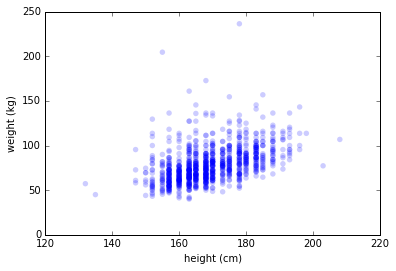

In [14]:
thinkplot.Scatter(heights, weights)
thinkplot.Config(xlabel='height (cm)',
                 ylabel='weight (kg)',
                 legend=False)

The outliers stretch the bounds of the figure, making it harder to see the shape of the core.  We can adjust the limits by hand.

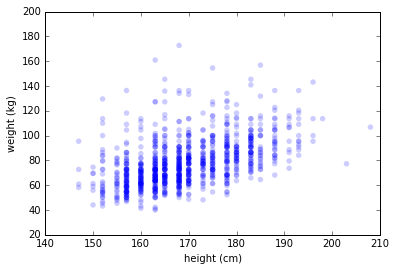

In [15]:
thinkplot.Scatter(heights, weights)
thinkplot.Config(xlabel='height (cm)',
                 ylabel='weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

The data points fall in columns because the heights were collected in inches and converted to cm.  We can smooth this out by jittering the data.

In [16]:
heights = thinkstats2.Jitter(heights, 2.0)
weights = thinkstats2.Jitter(weights, 0.5)

The following figure shows the effect of jittering.

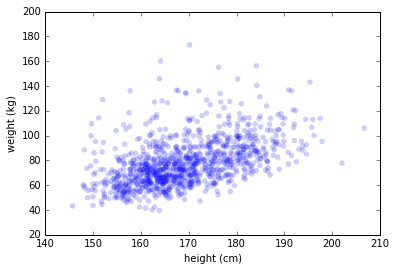

In [17]:
thinkplot.Scatter(heights, weights)
thinkplot.Config(xlabel='height (cm)',
                 ylabel='weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

With only 1000 samples, this works fine, but if we scale up to 10,000, we have a problem.

In [22]:
sample = thinkstats2.SampleRows(complete, 10000)
heights = sample.htm3
weights = sample.wtkg2
heights = thinkstats2.Jitter(heights, 2.0)
weights = thinkstats2.Jitter(weights, 0.5)

In the highest density parts of the figure, the ink is saturated, so they are not as dark as they should be, and the outliers are darker than they should be.

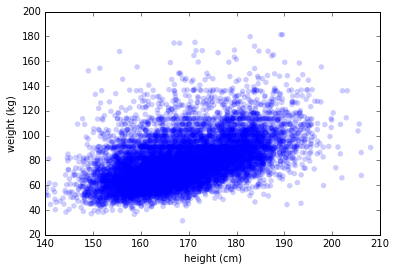

In [23]:
thinkplot.Scatter(heights, weights)
thinkplot.Config(xlabel='height (cm)',
                 ylabel='weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

This problem -- saturated scatter plots -- is amazingly common.  I see it all the time in published papers, even in good journals.

With moderate data sizes, you can avoid saturation by decreasing the marker size and `alpha`.

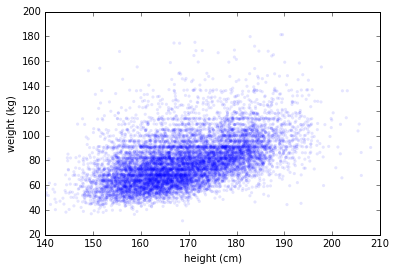

In [25]:
thinkplot.Scatter(heights, weights, alpha=0.1, s=10)
thinkplot.Config(xlabel='height (cm)',
                 ylabel='weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

That's better.  Although now the horizontal lines are more apparent, probably because people round their weight off to round numbers (in pounds).  We could address that by adding more jittering, but I will leave it alone for now.

If we increase the sample size again, to 100,000, we have to decrease the marker size and alpha level even more.

In [26]:
sample = thinkstats2.SampleRows(complete, 100000)
heights = sample.htm3
weights = sample.wtkg2
heights = thinkstats2.Jitter(heights, 3.5)
weights = thinkstats2.Jitter(weights, 1.5)

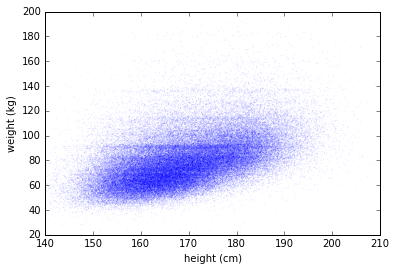

In [27]:
thinkplot.Scatter(heights, weights, alpha=0.1, s=1)
thinkplot.Config(xlabel='height (cm)',
                 ylabel='weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

Finally, we can generate a plot with the entire sample, about 395,000 respondents.

In [28]:
sample = complete
heights = sample.htm3
weights = sample.wtkg2
heights = thinkstats2.Jitter(heights, 3.5)
weights = thinkstats2.Jitter(weights, 1.5)

And I decreased the marker size one more time.

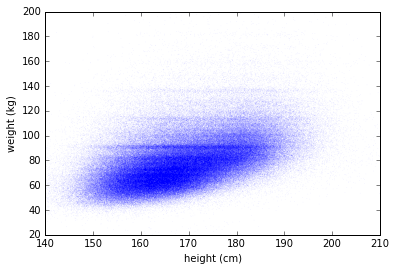

In [29]:
thinkplot.Scatter(heights, weights, alpha=0.07, s=0.5)
thinkplot.Config(xlabel='height (cm)',
                 ylabel='weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

This is about the best we can do, but it still has a few problems.  The biggest problem with this version is that it takes a long time to generate, and the resulting figure is big.

An alternative to a scatterplot is a hexbin plot, which divides the plane into hexagonal bins, counts the number of entries in each bin, and colors the hexagons in proportion to the number of entries.

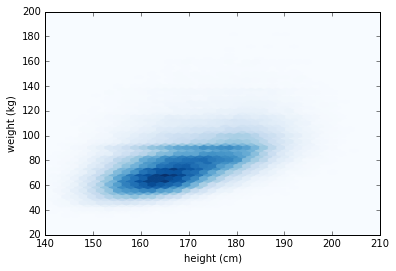

In [30]:
thinkplot.HexBin(heights, weights)
thinkplot.Config(xlabel='height (cm)',
                 ylabel='weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

The resulting figure is smaller and faster to generate, but it doesn't show all features of the scatterplot clearly.

There are a few other options for visualizing relationships between variables.  One is to group respondents by height and compute the CDF of weight for each group.

I use `np.digitize` and `DataFrame.groupby` to group respondents by height:

In [63]:
bins = np.arange(135, 210, 10)
print(bins)
indices = np.digitize(complete.htm3, bins)
groups = complete.groupby(indices)


[135 145 155 165 175 185 195 205]


Then I compute a CDF for each group (except the first and last).

In [64]:
mean_heights = [group.htm3.mean() for i, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.wtkg2) for i, group in groups][1:-1]


The following plot shows the distributions of weight.

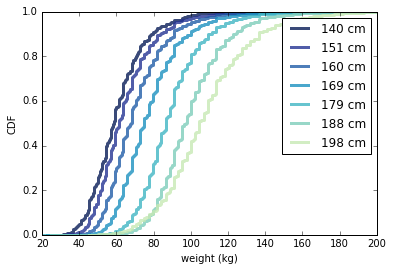

In [65]:
thinkplot.PrePlot(7)
for mean, cdf in zip(mean_heights, cdfs):
    thinkplot.Cdf(cdf, label='%.0f cm' % mean)
    
thinkplot.Config(xlabel='weight (kg)',
                 ylabel='CDF',
                 axis=[20, 200, 0, 1],
                 legend=True)

Using the CDFs, we can read off the percentiles of weight for each height group, and plot these weights agains the mean height in each group.

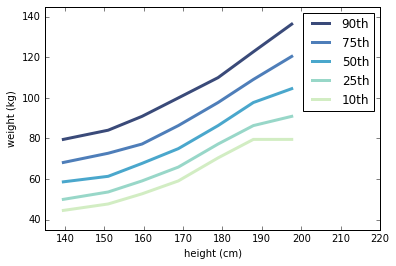

In [66]:
thinkplot.PrePlot(5)
for percent in [90, 75, 50, 25, 10]:
    weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(mean_heights, weight_percentiles, label=label)
    
thinkplot.Config(xlabel='height (cm)',
                 ylabel='weight (kg)',
                 axis=[135, 220, 35, 145],
                 legend=True)

This figure shows more clearly that the relationship between these variables is non-linear.  Based on background information, I expect the distribution of weight to be lognormal, so I would try plotting weight on a log scale.

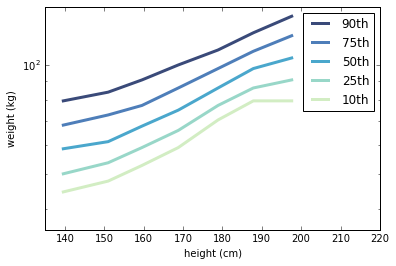

In [67]:
thinkplot.PrePlot(5)
for percent in [90, 75, 50, 25, 10]:
    weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(mean_heights, weight_percentiles, label=label)
    
thinkplot.Config(xlabel='height (cm)',
                 ylabel='weight (kg)',
                 yscale='log',
                 axis=[135, 220, 35, 145],
                 legend=True)

That relationship looks more linear, although not perfectly.

Correlation
-----------

After looking at a scatterplot, if you conclude that the relationship is at least approximately linear, you could compute a coefficient of correlation to quantify the strength of the relationship.

In [68]:
heights.corr(weights)

0.48000734053766198

A correlation of $\rho = 0.48$ is moderately strong -- I'll say more about what that means in a minute.

Since the relationship is more linear under a log transform, we might transform weight first, before computing the correlation.

In [69]:
heights.corr(np.log(weights))

0.50125544452163673

As expected, the correlation is a little higher with the transform.

Spearman's rank correlation can measure the strength of a non-linear relationship, provided it is monotonic.

In [70]:
heights.corr(weights, method='spearman')

0.50941335171388058

And Spearman's correlation is a little stronger still.

Remember that correlation measures the strength of a linear relationship, but says nothing about the slope of the line that relates the variables.

We can use `LeastSquares` to estimate the slope of the least squares fit.

In [71]:
inter, slope = thinkstats2.LeastSquares(heights, weights)
inter, slope

(-66.028661453741336, 0.85866796179740135)

So each additional cm of height adds almost a kilo of weight!

Here's what that line looks like, superimposed on the scatterplot:

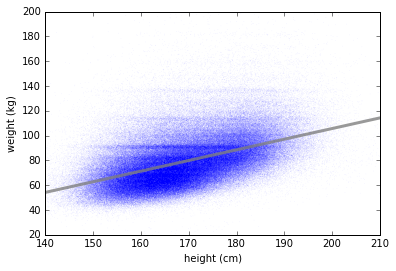

In [72]:
fit_xs, fit_ys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Scatter(heights, weights, alpha=0.07, s=0.5)
thinkplot.Plot(fit_xs, fit_ys, color='gray')
thinkplot.Config(xlabel='height (cm)',
                 ylabel='weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

The fit line is a little higher than the visual center of mass because it is being pulled up by the outliers.

Here's the same thing using the log transform:

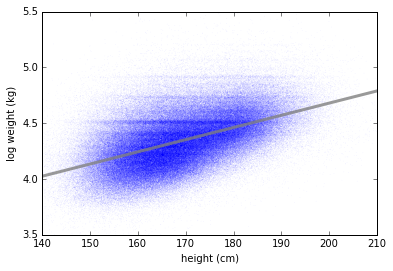

In [73]:
log_weights = np.log(weights)
inter, slope = thinkstats2.LeastSquares(heights, log_weights)
fit_xs, fit_ys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Scatter(heights, log_weights, alpha=0.07, s=0.5)
thinkplot.Plot(fit_xs, fit_ys, color='gray')
thinkplot.Config(xlabel='height (cm)',
                 ylabel='log weight (kg)',
                 axis=[140, 210, 3.5, 5.5],
                 legend=False)

That looks better, although maybe still not the line a person would have drawn.

The residuals are the distances between each point and the fitted line.

In [74]:
inter, slope = thinkstats2.LeastSquares(heights, weights)
res = thinkstats2.Residuals(heights, weights, inter, slope)

The coefficient of determination $R^2$ is the fraction of the variance in weight we can eliminate by taking height into account.

In [75]:
var_y = weights.var()
var_res = res.var()
R2 = 1 - var_res / var_y
R2

0.23040899121141534

The value $R^2 = 0.23$ indicates a moderately strong relationship.

Note that the coefficient of determination is related to the coefficient of correlation, $\rho^2 = R^2$.  So if we compute the sqrt of $R^2$, we should get $\rho$.

In [76]:
math.sqrt(R2)

0.48000936575385206

And here's the correlation again:

In [77]:
thinkstats2.Corr(heights, weights)

0.48000734053766203

If you see a high value of $\rho$, you should not be too impressed.  If you square it, you get $R^2$, which you can interpret as the decrease in variance if you use the predictor (height) to guess the weight.

But even the decrease in variance overstates the practical effect of the predictor.  A better measure is the decrease in root mean squared error (RMSE).

In [78]:
RMSE_without = weights.std()
RMSE_without

19.603506302983146

If you guess weight without knowing height, you expect to be off by 19.6 kg on average.

In [79]:
RMSE_with = res.std()
RMSE_with

17.197437874064118

If height is known, you can decrease the error to 17.2 kg on average.

In [ ]:
(1 - RMSE_with / RMSE_without) * 100

So knowing height improves your guesses/predictions by about 12%.